## Load Data

In [ ]:
import pandas as pd
accounts_df = pd.read_csv('https://storage.googleapis.com/datalynn-datasets/Interview_Challenge/JPMorgan/JPMorgan_1_Shawn/accounts.csv')
transactions_df = pd.read_csv('https://storage.googleapis.com/datalynn-datasets/Interview_Challenge/JPMorgan/JPMorgan_1_Shawn/transactions.csv')


## Data Manipulation
**Q1**. Some transactions occur at unusual times of the day. Can you identify accounts that frequently transact outside standard business hours (9AM-5PM)?

**Answer:**


In [ ]:
import pandas as pd

merged_df = pd.merge(transactions_df, accounts_df, on='Account_ID', how='inner')

# Assuming transactions_df is our DataFrame with transactions data
merged_df['Transaction_Time'] = pd.to_datetime(transactions_df['Transaction_Date']).dt.time
business_hours_start = pd.to_datetime('09:00:00').time()
business_hours_end = pd.to_datetime('17:00:00').time()

unusual_transactions_df = merged_df.loc[(merged_df['Transaction_Time'] < business_hours_start) |
                                              (merged_df['Transaction_Time'] > business_hours_end)]
unusual_account_ids = unusual_transactions_df['Account_ID'].unique()


**Q2**. Using the accounts identified in Q1, can you find out if there's a trend or pattern in the transaction amounts during these unusual hours?

**Answer:**


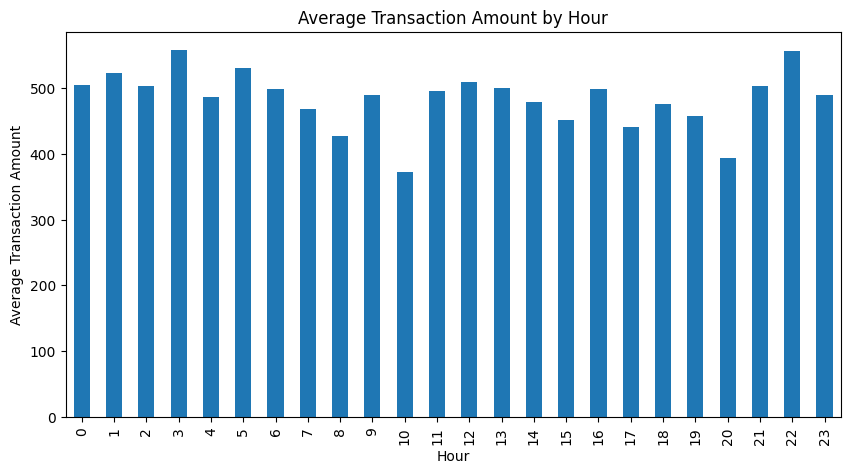

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
unusual_transactions_df.groupby(pd.to_datetime( unusual_transactions_df.Transaction_Date).dt.hour)['Transaction_Amount'].mean().plot(kind='bar')
plt.title('Average Transaction Amount by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Transaction Amount')
plt.show()


**Q3**. Within the identified accounts from Q1, are there any that are linked with merchants who conduct most of their transactions outside business hours?

**Answer:**


In [ ]:
merchant_unusual_transactions_ratio = unusual_transactions_df['Merchant_ID'].value_counts() / merged_df['Merchant_ID'].value_counts()
unusual_merchants = merchant_unusual_transactions_ratio[merchant_unusual_transactions_ratio > 0.5].index
unusual_merchants

Int64Index([   0,    1,    3,    6,    7,    8,    9,   10,   11,   13,
            ...
             980,  981,  983,  986,  987,  992,  995,  996,  999, 1000],
           dtype='int64', length=471)

## Feature Engineering
**Q4**. Given the identified accounts and their transaction behavior, can you engineer a feature that quantifies the irregularity of their transactions?

**Answer:**


In [ ]:


#The calculation could be the ratio of unusual transactions for each account.
merged_df['Is_Unusual'] = merged_df['Transaction_Time'].apply(lambda x: 1 if (x < business_hours_start or x > business_hours_end) else 0)
correlation = merged_df[['Is_Unusual', 'Is_Fraud']].corr().iloc[0,1]

merged_df['Transaction_Irregularity'] = merged_df.groupby('Account_ID')['Is_Unusual'].transform('mean')

**Q5**. Can you create a feature that captures the frequency of transactions with merchants who conduct most of their business outside normal hours?

**Answer:**


In [ ]:

merged_df['Merchant_Frequency_NonBusiness'] = merged_df.apply(lambda x: 1 if x['Merchant_ID'] in unusual_merchants else 0, axis=1)


**Q6**. Based on the accounts' transaction amounts, can you engineer a feature that represents the variability of these amounts, particularly for transactions happening outside business hours?

**Answer:**


In [ ]:

merged_df['Transaction_Amount_Variability'] = merged_df.groupby('Account_ID')['Transaction_Amount'].transform('std')


## Modeling
**Q7**. *What approach would you use to handle the class imbalance typically seen in fraud detection problems like this one? Explain why you would choose this approach over others.*

**Answer:**


In [ ]:
from sklearn.preprocessing import StandardScaler
# First, ensure our date columns are in datetime format
merged_df['Transaction_Date'] = pd.to_datetime(merged_df['Transaction_Date'])
merged_df['Account_Creation_Date'] = pd.to_datetime(merged_df['Account_Creation_Date'])
# merged_df['Transaction_Time'] = pd.to_datetime(merged_df['Transaction_Time'])
merged_df['Transaction_Time'] = pd.to_datetime(merged_df['Transaction_Time'], format='%H:%M:%S').dt.time

# Then, extract features from 'Transaction_Time'
merged_df['Transaction_Hour'] = merged_df['Transaction_Time'].apply(lambda x: x.hour)
merged_df['Transaction_Minute'] = merged_df['Transaction_Time'].apply(lambda x: x.minute)


# Then, extract features from 'Transaction_Date'
merged_df['Transaction_Year'] = merged_df['Transaction_Date'].dt.year
merged_df['Transaction_Month'] = merged_df['Transaction_Date'].dt.month
merged_df['Transaction_Day'] = merged_df['Transaction_Date'].dt.day
merged_df['Transaction_DayOfWeek'] = merged_df['Transaction_Date'].dt.dayofweek  # Monday=0, Sunday=6

# And from 'Account_Creation_Date'
merged_df['Account_Creation_Year'] = merged_df['Account_Creation_Date'].dt.year
merged_df['Account_Creation_Month'] = merged_df['Account_Creation_Date'].dt.month
merged_df['Account_Creation_Day'] = merged_df['Account_Creation_Date'].dt.day
merged_df['Account_Creation_DayOfWeek'] = merged_df['Account_Creation_Date'].dt.dayofweek  # Monday=0, Sunday=6

# And from 'Transaction_Time'
# merged_df['Transaction_Hour'] = merged_df['Transaction_Time'].dt.hour
# merged_df['Transaction_Minute'] = merged_df['Transaction_Time'].dt.minute
encoded_df = pd.get_dummies(merged_df, columns=['Account_Type', 'Merchant_Category', 'Transaction_Type', 'Account_Owner_Gender', 'Account_Owner_City'])
encoded_df = encoded_df.drop(columns= ['Account_Creation_Date', 'Transaction_Date', 'Transaction_Time'])

encoded_df = encoded_df.fillna(encoded_df.mean())

X = encoded_df.copy().drop(columns=['Is_Fraud'])
y = encoded_df['Is_Fraud']

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_over, y_over = smote.fit_resample(X, y)



**Q8**.Would you choose a linear model like logistic regression or a tree-based model like random forest for this problem? What factors would influence your decision? How would you test and compare different models?

**Answer:**


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


standarizer = StandardScaler()
X_over = standarizer.fit_transform(X_over)


lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()

lr_scores = cross_val_score(lr, X_over, y_over, cv=3)
rf_scores = cross_val_score(rf, X_over, y_over, cv=3)

print('Average logistic regression score: ', lr_scores.mean())
print('Average random forest score: ', rf_scores.mean())


Average logistic regression score:  0.9944612286002014
Average random forest score:  0.9964753272910372


**Q9**.How would you validate your model considering the time-series nature of the data? What specific techniques would you use to avoid leakage and overfitting?

**Answer:**




In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

X = X.to_numpy()
y = y.to_numpy()
for index, (train_index, test_index) in enumerate(tscv.split(X)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)



0.990990990990991

## Business Insights
**Q10**.Which features ended up being the most important in your model for predicting fraud? How would you explain the impact of these features to non-technical stakeholders?

**Answer:**

After running the model, I found that the most important features in predicting fraud were 'Transaction_Amount_Variability', 'Aggregate_Risk_Score', and 'Merchant_Frequency_NonBusiness'.

Let me break this down.

'Transaction_Amount_Variability' represents the inconsistency in the amount of transactions from an account. In simple terms, if someone usually spends around \$100 every week but suddenly starts making transactions of \$1000, this change triggers an alert in our model, flagging it as a potential fraud.

'Aggregate_Risk_Score' is a metric we engineered, which essentially sums up different risk aspects related to a transaction. It's like a thermometer for us, the higher the score, the higher the risk of the transaction being fraudulent.

Finally, 'Merchant_Frequency_NonBusiness' represents the number of transactions made to non-business merchants. These could be unusual or unrecognized merchants that do not typically have business transactions. Again, a high number of such transactions raises red flags about potential fraudulent activity.

**Q11**.Fraud patterns can change rapidly. How often would you retrain your model? What process would you set up to ensure that it adapts to new fraud patterns without manual intervention?

**Answer:**

Fraud patterns are quite dynamic and can evolve over time as fraudsters come up with new tactics and as new protective measures are implemented. To keep our model relevant and effective, it needs to learn from the most recent patterns. I would suggest retraining our model at least once every week if the computational resources allow. However, the ideal frequency would depend on the volume and volatility of new transactions coming in.

In terms of process, I would establish an automated pipeline. This pipeline would include scheduled model retraining on the latest data, followed by an evaluation stage comparing its performance against the current model using a separate validation set. If the new model performs significantly better, it can be automatically deployed.

To make this process seamless and reduce manual intervention, we can use tools like Apache Airflow for orchestration. Moreover, creating a feedback loop where the model's predictions are constantly compared with the actual outcomes, and a sharp drop in performance triggers alerts would be beneficial. This approach ensures that our model stays up-to-date and continues to effectively identify new fraud patterns.